In [1]:
#Imports
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import os
from scipy.interpolate import interp1d, CubicSpline
from tqdm import tqdm
from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline
from scipy.signal import qspline1d, qspline1d_eval
from scipy.signal import medfilt
from astropy.modeling import models, fitting
from astropy.stats import sigma_clip
import time
from glob import glob


%matplotlib inline

In [2]:
rv_tmplt_directory = "C:\\Users\\nachi\\OneDrive\\Desktop\\Hawkins Lab\\datasets\\RVgrid"
conv_tmplt_list = glob(os.path.join(rv_tmplt_directory,"*.conv"))
len(conv_tmplt_list)

730

In [3]:
tmplt_specs = []
tmplt_wavelengths = []
tmplt_norm_og = []
observed_wavelengths = np.linspace(3500,5500,1036)
for i in range(len(conv_tmplt_list)):
    current = np.loadtxt(conv_tmplt_list[i])
    tmplt_specs.append(current[:,2])
    tmplt_wavelengths.append(current[:,0])
    tmplt_norm_og.append(current[:,1])
    

In [4]:
observed_wavelengths = np.linspace(3500,5500,1036)

refit_tmplt_spec_arr = []

for i in range(len(tmplt_specs)):
    cs = CubicSpline(tmplt_wavelengths[i],tmplt_specs[i])
    refit_tmplt_spec = np.array(cs(observed_wavelengths))
    refit_tmplt_spec_arr.append(refit_tmplt_spec)

refit_tmplt_spec_arr = np.array(refit_tmplt_spec_arr)

In [6]:
#Implementing Boosted Median Continuum On Spectra
BMC_timings = [] #Stores the time taken to perform each BMC operation (just to check effeciency for fun)
normalized_spectra = [] #Stores the normalized spectra
continuums = [] #Stores the continuums of the spectra

def BMC(resampled_flux,window_size=50,percentile=0.98,BMC_timings=[],normalized_spectra=[],continuums=[]):

    start = time.perf_counter()

    spec_len = len(resampled_flux) 
    half_window_size = window_size//2 #We do this because the window is centered around the current value being determined. i.e index 100 will consider indecies 51-150 as part of the window
    percentile_idx = int(percentile * window_size) #Since the 
    first_reflection = resampled_flux[:half_window_size][::-1]
    second_reflection = resampled_flux[-half_window_size:][::-1]
    extended_flux = np.concatenate([first_reflection,resampled_flux,second_reflection])

    running_stack = sorted(extended_flux[:window_size]) #Stars as a sorted list of the first 100 
    continuum = [] #Because the window doesn't move until the index == half_window_size, you're still taking the nth percentile of resampled_flux[:window_size]

    for i in range(half_window_size, spec_len + half_window_size):
        #remove operation
        removal_val = extended_flux[i-half_window_size]
        removal_idx = np.searchsorted(running_stack,removal_val) #Binary search to remove i-half_window_size value as the window has moved forward by 1
        del running_stack[removal_idx]

        #insert operation
        insertion_val = extended_flux[i+half_window_size]
        insertion_idx = np.searchsorted(running_stack,insertion_val) #Binary search to insert the value into the running stack which is always sorted
        running_stack.insert(insertion_idx,insertion_val)

        continuum_val = running_stack[percentile_idx] 
        continuum.append(continuum_val) 

    continuum = np.array(continuum)
    normalized = resampled_flux/continuum

    finish = time.perf_counter()
    
    BMC_timings.append(finish-start)
    normalized_spectra.append(normalized)
    continuums.append(continuum)

for resampled_flux in tqdm(refit_tmplt_spec_arr):
    BMC(resampled_flux,50,0.98,BMC_timings,normalized_spectra,continuums)

100%|██████████| 730/730 [00:07<00:00, 91.70it/s] 


In [5]:
#Implementing Boosted Median Continuum On Spectra
BMC_timings = [] #Stores the time taken to perform each BMC operation (just to check effeciency for fun)
normalized_spectra = [] #Stores the normalized spectra
continuums = [] #Stores the continuums of the spectra

def BMC(resampled_flux,window_size=50,percentile=0.98,BMC_timings=[],normalized_spectra=[],continuums=[]):

    start = time.perf_counter()

    spec_len = len(resampled_flux) 
    half_window_size = window_size//2 #We do this because the window is centered around the current value being determined. i.e index 100 will consider indecies 51-150 as part of the window
    running_stack = sorted(resampled_flux[:window_size]) #Stars as a sorted list of the first 100 
    percentile_idx = int(percentile * window_size) #Since the 
    continuum = [running_stack[percentile_idx]] * half_window_size #Because the window doesn't move until the index == half_window_size, you're still taking the nth percentile of resampled_flux[:window_size]

    for i in range(half_window_size, spec_len-half_window_size):

        #remove operation
        removal_val = resampled_flux[i-half_window_size]
        removal_idx = np.searchsorted(running_stack,removal_val) #Binary search to remove i-half_window_size value as the window has moved forward by 1
        del running_stack[removal_idx]

        #insert operation
        insertion_val = resampled_flux[i+half_window_size]
        insertion_idx = np.searchsorted(running_stack,insertion_val) #Binary search to insert the value into the running stack which is always sorted
        running_stack.insert(insertion_idx,insertion_val)

        continuum_val = running_stack[percentile_idx] 
        continuum.append(continuum_val) 

    continuum += [running_stack[percentile_idx]] * half_window_size #Window remains stationary for the last half_window_size values so we append the same value
    continuum = np.array(continuum)
    normalized = resampled_flux/continuum

    finish = time.perf_counter()
    
    BMC_timings.append(finish-start)
    normalized_spectra.append(normalized)
    continuums.append(continuum)

for resampled_flux in tqdm(refit_tmplt_spec_arr):
    BMC(resampled_flux,50,0.98,BMC_timings,normalized_spectra,continuums)

100%|██████████| 730/730 [00:07<00:00, 94.32it/s] 


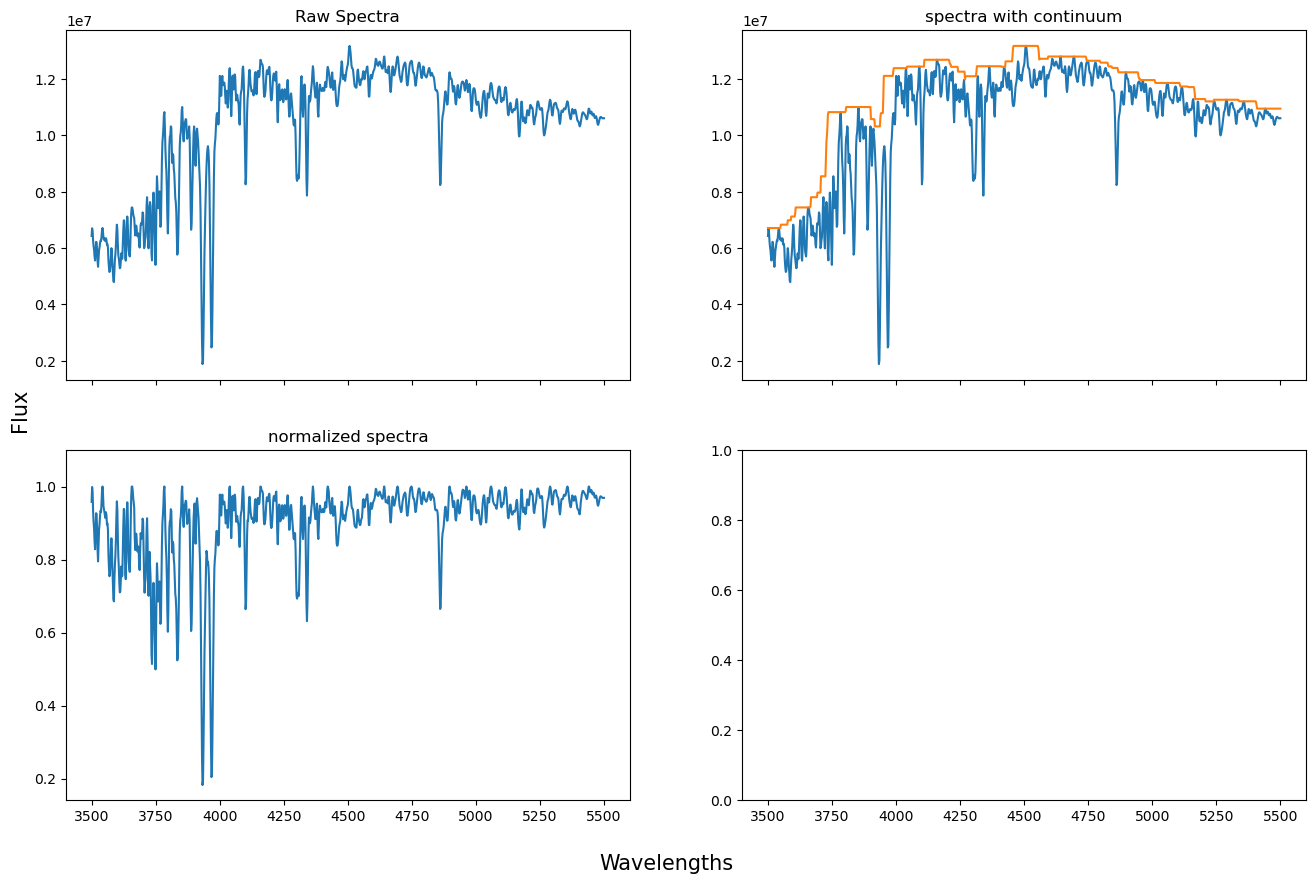

In [6]:
#Plotting graphs
idx = 500 #change this to the idx of the spectra you want to see
continuum = continuums[idx]
normalized = normalized_spectra[idx]
resampled_flux = refit_tmplt_spec_arr[idx]

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(16, 10),sharex=True)


ax1.plot(observed_wavelengths,resampled_flux)
ax1.set_title("Raw Spectra")

ax2.plot(observed_wavelengths,resampled_flux)
ax2.plot(observed_wavelengths,continuum)

ax2.set_title("spectra with continuum")

ax3.plot(observed_wavelengths,normalized)
ax3.set_ylim(top=max(normalized)+0.1)
ax3.set_title("normalized spectra")
fig.text(0.5, 0.04, 'Wavelengths', ha='center',size=15)
fig.text(0.09, 0.5, 'Flux', va='center', rotation='vertical',size=15)
plt.show()

ax4.plot(tmplt_wavelengths[idx],tmplt_norm_og[idx])
ax4.set_ylim(top=max(normalized)+0.1)
ax4.set_title("normalized spectra")
fig.text(0.5, 0.04, 'Wavelengths', ha='center',size=15)
fig.text(0.09, 0.5, 'Flux', va='center', rotation='vertical',size=15)
plt.show()

In [10]:
len(normalized)

1036

In [7]:
t = Table([tmplt_specs,tmplt_wavelengths,continuums,normalized_spectra,tmplt_norm_og,refit_tmplt_spec_arr],names=("specs","wavelengths","continuums","norm_specs","og_norm","refit_tmplt"))

In [8]:
from astropy.io import fits
dataset_dir = "C:\\Users\\nachi\\OneDrive\\Desktop\\Hawkins Lab\\datasets"
modified_data_path = os.path.join(dataset_dir,"UPDATED_TEMPELATE_SPECTRA.fits")
hdu = fits.BinTableHDU(t)
hdu.writeto(modified_data_path,overwrite=True)

In [9]:
#Checking if the changes have been added
dataset_dir = "C:\\Users\\nachi\\OneDrive\\Desktop\\Hawkins Lab\\datasets"
spec_data_path = os.path.join(dataset_dir,"UPDATED_TEMPELATE_SPECTRA.fits")
spec_data = Table.read(spec_data_path)
for name in sorted(spec_data.colnames):
    print(name)

continuums
norm_specs
og_norm
refit_tmplt
specs
wavelengths
